 # MTH8408 : Méthodes d'optimisation et contrôle optimal
 ## Laboratoire 3: Optimisation sans contraintes et méthodes itératives
Tangi Migot et Paul Raynaud

Nom : Mohamed Laghdaf HABIBOULLAH

In [37]:
using LinearAlgebra, NLPModels, Printf

In [2]:
#Test problem:
using ADNLPModels
fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
x0H = [10., 20.]
himmelblau = ADNLPModel(fH, x0H)

problem2 = ADNLPModel(x->-x[1]^2, ones(3))

roz(x) = 100 *  (x[2] - x[1]^2)^2 + (x[1] - 1.0)^2
rosenbrock = ADNLPModel(roz, [-1.2, 1.0])

f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
pb_du_cours = ADNLPModel(f, [-1.001, -1.001]) #ou [1.5, .5] ou [.5, .5]

ADNLPModel - Model with automatic differentiation backend ADModelBackend{
  ForwardDiffADGradient,
  ForwardDiffADHvprod,
  ForwardDiffADJprod,
  ForwardDiffADJtprod,
  SparseForwardADJacobian,
  ForwardDiffADHessian,
  ForwardDiffADGHjvprod,
}
  Problem name: Generic
   All variables: ████████████████████ 2      All constraints: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            free: ████████████████████ 2                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (  0.00% sparsity)   3               linear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
   

## Commentaires sur Julia

Quelques commentaires sur des morceaux de codes que vous avez vu:
- les structures, exemple [GenericExecutionStats](https://github.com/JuliaSmoothOptimizers/SolverCore.jl/blob/0091f437a26a27ac8aa53d5e37647223722f7f7c/src/stats.jl#L60) (constructeur, attribut, type).


In [3]:
using SolverCore

- Les arguments dans les fonctions. Lire attentivement [la documentation Julia sur les fonctions](https://docs.julialang.org/en/v1/manual/functions/) pour comprendre l'utilisation des `Optional Arguments` et des `Keywords Arguments`. Ce type d'arguments est très utile dans nos applictions où les solveurs dépendent de paramètre dont on peut fixer des valeurs par défaut.

## Exercice 1: Méthode BFGS avec mémoire limitée (L-BFGS)

Le but de cet exercice est d'implémenter la méthode BFGS à mémoire limitée vue en cours en utilisant les `InverseLBFGSOperator` du package `LinearOperators.jl`. Il y a aussi un petit exemple dans la documentation du package [LinearOperators.jl/dev/tutorial/#Limited-memory-BFGS-and-SR1](https://juliasmoothoptimizers.github.io/LinearOperators.jl/dev/tutorial/#Limited-memory-BFGS-and-SR1).

In [11]:
using LinearOperators

In [ ]:
? InverseLBFGSOperator

ce qui est important dans ce type de méthode est:
- le paramètre mémoire
- la mise à jour de l'opérateur avec la fonction `push!`
- si on a pas une direction de descente, alors on skip
- recherche linéaire d'Armijo

In [ ]:
? LinearOperators.push!

In [12]:
"""
    armijo(xk, dk, fk, gk, slope, nlp :: AbstractNLPModel; τ1 = 1.0e-4, t_update = 1.5)

Recherche linéaire d'Armijo
"""

function armijo(xk, dk, fk, gk, slope, nlp :: AbstractNLPModel; τ1 = 1.0e-4, t_update = 1.5)
  t = 1.0
  fk_new = obj(nlp, xk + dk) # t = 1.0
  while fk_new > fk + τ1 * t * slope
    t /= t_update
    fk_new = obj(nlp, xk + t * dk)
  end
  return t, fk_new
end

armijo (generic function with 1 method)

In [14]:
"""
    limited_bfgs(nlp::AbstractNLPModel; x = nlp.meta.x0, atol = √eps(eltype(x)), rtol = √eps(eltype(x)),
                 max_eval = -1, max_time = 30.0, f_min = -1.0e16, verbose = true, mem = 5)

Résolution d'un problème d'optimisation non linéaire par la méthode de BFGS limitée.
"""

function limited_bfgs(nlp      :: AbstractNLPModel;
                      x        :: AbstractVector = nlp.meta.x0,
                      atol     :: Real = √eps(eltype(x)), 
                      rtol     :: Real = √eps(eltype(x)),
                      max_eval :: Int = -1,
                      max_time :: Float64 = 30.0,
                      f_min    :: Float64 = -1.0e16,
                      verbose  :: Bool = true,
                      mem      :: Int = 5)
  start_time = time()
  elapsed_time = 0.0

  T = eltype(x)
  n = nlp.meta.nvar

  xt = zeros(T, n)
  ∇ft = zeros(T, n)

  f = obj(nlp, x)
  ∇f = grad(nlp, x)
#################################################
  ### Use InverseLBFGSOperator instead of I ###
  H = InverseLBFGSOperator(n, mem)
#################################################

  ∇fNorm = norm(∇f) #nrm2(n, ∇f)
  ϵ = atol + rtol * ∇fNorm
  iter = 0

  @info log_header([:iter, :f, :dual, :slope, :bk], [Int, T, T, T, T],
                   hdr_override=Dict(:f=>"f(x)", :dual=>"‖∇f‖", :slope=>"∇fᵀd"))

  optimal = ∇fNorm ≤ ϵ
  unbdd = f ≤ f_min
  tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
  stalled = false
  status = :unknown

  while !(optimal || tired || stalled || unbdd)

#################################################
    d = -H * ∇f
#################################################
    slope = dot(d, ∇f)
    if slope ≥ 0
      @error "not a descent direction" slope
      status = :not_desc
      stalled = true
      continue
    end

    # Perform improved Armijo linesearch.
    t, ft = armijo(x, d, f, ∇f, slope, nlp)
        
    @info log_row(Any[iter, f, ∇fNorm, slope, t])

    # Update L-BFGS approximation.
    xt = x + t * d
    ∇ft = grad(nlp, xt) # grad!(nlp, xt, ∇ft)
#################################################
    push!(H, xt - x, ∇ft - ∇f) ### Update H
#################################################

    # Move on.
    x = xt
    f = ft
    ∇f = ∇ft

    ∇fNorm = norm(∇f) #nrm2(n, ∇f)
    iter = iter + 1

    optimal = ∇fNorm ≤ ϵ
    unbdd = f ≤ f_min
    elapsed_time = time() - start_time
    tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
  end
  @info log_row(Any[iter, f, ∇fNorm])

  if optimal
    status = :first_order
  elseif tired
    if neval_obj(nlp) > max_eval ≥ 0
      status = :max_eval
    elseif elapsed_time > max_time
      status = :max_time
    end
  elseif unbdd
        status = :unbounded
  end

  return GenericExecutionStats(
        nlp,
        status=status,
        solution=x,
        objective=f,
        dual_feas=∇fNorm,
        iter=iter,
        elapsed_time=elapsed_time,
    )
end

limited_bfgs (generic function with 1 method)

In [19]:
#Unit/Validation Tests
# Réaliser un test unitaire

#using Pkg; Pkg.add("Test")
using Test
# Demander le test secret pour lbfgs
@testset begin
    #Unit/Validation Tests
    using Logging, Test
    stats = with_logger(NullLogger()) do 
        limited_bfgs(himmelblau) 
    end
    @test stats.status == :first_order
    @test stats.solution ≈ [3.584428266659278, -1.8481265666485827] atol = 1e-6
    @show (stats.status, stats.solution)
    stats = with_logger(NullLogger()) do 
        limited_bfgs(problem2) 
    end
    @test stats.status == :unbounded
    @show (stats.status, stats.solution)
    stats = with_logger(NullLogger()) do 
        limited_bfgs(rosenbrock) 
    end
    @test stats.solution ≈ [1., 1.] atol = 1e-6
    @show (stats.status, stats.solution)
    stats = with_logger(NullLogger()) do 
        limited_bfgs(pb_du_cours, x = [-1.001, -1.001]) 
    end
    @test stats.status == :unbounded
    @show (stats.status, stats.solution)
    stats = with_logger(NullLogger()) do 
        limited_bfgs(pb_du_cours, x = [1.5, .5]) 
    end
    @test stats.status == :first_order
    @test stats.solution ≈ [1., 0.] atol = 1e-6
    @show (stats.status, stats.solution)
    stats = with_logger(NullLogger()) do 
        limited_bfgs(pb_du_cours, x = [.5, .5]) 
    end
    @test stats.status == :first_order
    @test stats.solution ≈ [1., 0.] atol = 1e-6
    @show (stats.status, stats.solution)
end


(stats.status, stats.solution) = (:first_order, [3.584428266659278, -1.8481265666485827])
(stats.status, stats.solution) = (:unbounded, [1.29140163e8, 1.0, 1.0])
(stats.status, stats.solution) = (:first_order, [0.9999999887950609, 0.9999999782159007])
(stats.status, stats.solution) = (:unbounded, [-975544.6834173689, -764227.9241466719])
(stats.status, stats.solution) = (:first_order, [0.9999999962625671, -3.1168149972852375e-9])
(stats.status, stats.solution) = (:first_order, [0.99999999073849, -6.6173734939441815e-9])
Test Summary: | Pass  Total  Time
test set      |    9      9  0.0s


Test.DefaultTestSet("test set", Any[], 9, false, false, true, 1.707156888376989e9, 1.707156888411113e9)

### Bonus:

- Compare l'implémentation de `limited_bfgs` avec la fonction `lbfgs` qui est disponible dans `JSOSolvers.jl`.
- On veut pouvoir tester "facilement" plusieurs valeurs de $\tau$ et du paramètre de mise à jour dans `armijo` sur les problèmes tests. Comment modifier le code pour que ça soit possible?

On peut mesurer deux executions de fonctions Julia grâce aux fonctions de `BenchmarkTools.jl`:

In [16]:
using BenchmarkTools

## Exercice 2: NewtonCG

Le but de cet exercice est d'adapter les méthodes de Newton de façon à résoudre le système linéaire avec une méthode itérative de type gradient conjugué comme suit ($B_k$ représente la matrice hessienne):

<img src="LineSearchNewtonCG.png" width=600 height=600 />

In [26]:
"""
    cg_optim(H, ∇f)

Résoudre le système linéaire Hx = -∇f en utilisant la méthode du gradient conjugué.

"""

function cg_optim(H, ∇f)
    #setup the tolerance:
    n∇f = norm(∇f)
#####################################
    ϵk = min(0.5, sqrt(n∇f)) * n∇f
####################################
    n = length(∇f)
    z = zeros(n)
    r = ∇f
    d = -r
    
    j = 0
    while norm(r) ≥ ϵk && j < 3 * n
###############################################
        if dot(d, H * d) ≤ 0
            # TODO
            if j == 0
                return d
            else
                return z
            end
        end
##############################################
        α = dot(r, r) / dot(d, H * d)
##############################################        
        z += α * d
        nrr2 = dot(r, r)
        r += α * H * d
##############################################
        β  = dot(r, r) / nrr2
##############################################
        d  = -r + β * d
        j += 1
    end
    return z
end

cg_optim (generic function with 1 method)

Ce qui est important ici est qu'on a pas besoin de stocker/évaluer la matrice hessienne entière mais simplement le produit entre la hessienne et un vecteur. Pour un `NLPModels` on utilise:

In [ ]:
? NLPModels.hprod

In [ ]:
? NLPModels.hess_op

In [29]:
"""
    armijo_Newton_cg(nlp; x = nlp.meta.x0, atol = √eps(eltype(x)), rtol = √eps(eltype(x)),
                    max_eval = -1, max_time = 30.0, f_min = -1.0e16)

Résoudre un problème d'optimisation non linéaire en utilisant la méthode de Newton avec une recherche linéaire de type Armijo et une méthode de recherche de direction de type CG.
"""

function armijo_Newton_cg(nlp      :: AbstractNLPModel;
                          x        :: AbstractVector = nlp.meta.x0,
                          atol     :: Real = √eps(eltype(x)), 
                          rtol     :: Real = √eps(eltype(x)),
                          max_eval :: Int = -1,
                          max_time :: Float64 = 30.0,
                          f_min    :: Float64 = -1.0e16)
  start_time = time()
  elapsed_time = 0.0

  T = eltype(x)
  n = nlp.meta.nvar

  f = obj(nlp, x)
  ∇f = grad(nlp, x)
#################################################
  H = hess_op(nlp, x)# Initialize H as linear operator representing the Hessian matrix
#################################################

  ∇fNorm = norm(∇f) #nrm2(n, ∇f)
  ϵ = atol + rtol * ∇fNorm
  iter = 0

  @info log_header([:iter, :f, :dual, :slope, :bk], [Int, T, T, T, T],
                   hdr_override=Dict(:f=>"f(x)", :dual=>"‖∇f‖", :slope=>"∇fᵀd"))

  optimal = ∇fNorm ≤ ϵ
  unbdd = f ≤ f_min
  tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
  stalled = false
  status = :unknown

  while !(optimal || tired || stalled || unbdd)
        
    d = cg_optim(H, ∇f)
        
    slope = dot(d, ∇f)
    if slope ≥ 0
      @error "not a descent direction" slope
      status = :not_desc
      stalled = true
      continue
    end

    # Perform improved Armijo linesearch.
    t, f = armijo(x, d, f, ∇f, slope, nlp)
        
    @info log_row(Any[iter, f, ∇fNorm, slope, t])

    # Update L-BFGS approximation.
    x += t * d
    ∇f = grad(nlp, x)
#################################################
    H = hess_op(nlp, x) # Update H
#################################################

    ∇fNorm = norm(∇f) #nrm2(n, ∇f)
    iter = iter + 1

    optimal = ∇fNorm ≤ ϵ
    unbdd = f ≤ f_min
    elapsed_time = time() - start_time
    tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
  end
  @info log_row(Any[iter, f, ∇fNorm])

  if optimal
    status = :first_order
  elseif tired
    if neval_obj(nlp) > max_eval ≥ 0
      status = :max_eval
    elseif elapsed_time > max_time
      status = :max_time
    end
  elseif unbdd
        status = :unbounded
  end

  return GenericExecutionStats(nlp, status = status, solution=x, objective=f, dual_feas=∇fNorm,
                               iter=iter, elapsed_time=elapsed_time)
end

armijo_Newton_cg (generic function with 1 method)

In [30]:
#Unit/Validation Tests
# Réaliser un test unitaire

using Test

# Demander le test secret pour newton-cg
@testset begin
    #Unit/Validation Tests
    using Logging, Test
    stats = with_logger(NullLogger()) do 
        armijo_Newton_cg(himmelblau) 
    end
    @test stats.status == :first_order
    @test stats.dual_feas ≤ 1e-6 + 1e-6 * norm(grad(himmelblau, himmelblau.meta.x0))
    @show (stats.status, stats.solution)
    stats = with_logger(NullLogger()) do 
        armijo_Newton_cg(problem2) 
    end
    @test stats.status == :unbounded
    @show (stats.status, stats.solution)
    stats = with_logger(NullLogger()) do 
        armijo_Newton_cg(rosenbrock) 
    end
    @test stats.solution ≈ [1., 1.] atol = 1e-5
    @show (stats.status, stats.solution)
    stats = with_logger(NullLogger()) do 
        armijo_Newton_cg(pb_du_cours, x = [-1.001, -1.001]) 
    end
    @test stats.status == :unbounded
    @show (stats.status, stats.solution)
    stats = with_logger(NullLogger()) do 
        armijo_Newton_cg(pb_du_cours, x = [1.5, .5]) 
    end
    @test stats.status == :first_order
    @test stats.solution ≈ [1., 0.] atol = 1e-6
    @show (stats.status, stats.solution)
    stats = with_logger(NullLogger()) do 
        armijo_Newton_cg(pb_du_cours, x = [.5, .5]) 
    end
    @test stats.status == :first_order
    @test stats.solution ≈ [1., 0.] atol = 1e-6
    @show (stats.status, stats.solution)
end


(stats.status, stats.solution) = (:first_order, [2.9999993048920612, 2.000003199723837])
(stats.status, stats.solution) = 

(:unbounded, [1.29140163e8, 1.0, 1.0])
(stats.status, stats.solution) = (:first_order, [0.999999476502548, 0.9999989509130072])
(stats.status, stats.solution) = 

(:unbounded, [-475732.37111010315, -259818.976413054])
(stats.status, stats.solution) = (:first_order, [1.000000000013107, 6.553566737834711e-12])
(stats.status, stats.solution) = (:first_order, [1.0000000000000009, 4.489396480695633e-16])
Test Summary: | Pass  Total  Time
test set      |    9      9  4.0s


Test.DefaultTestSet("test set", Any[], 9, false, false, true, 1.707161086011611e9, 1.70716109001706e9)

## Comment préparer un benchmark

On veut maintenant pouvoir réaliser un benchmark de plusieurs solveurs. Pour comparer les algorithmes, il nous faut une collection de problèmes tests et on va utiliser `OptimizationProblems.jl`.

In [17]:
using OptimizationProblems

Vous pouvez trouver un tutoriel de comment réaliser un benchmark avec ce package sur la documentation [OptimizationProblems.jl/dev/benchmark/](https://juliasmoothoptimizers.github.io/OptimizationProblems.jl/dev/benchmark/).

Il est fort possible que les petits problèmes tests que l'on résout après l'implémentation ne suffisent pas à déceler des bugs. Mais on peut toujours analyser l'éxecution de notre algorithme sur certains problèmes de la collection afin d'améliorer la valeur de certains paramètres (limite de temps, d'itérations, d'évaluations), détecter un bug, etc.

In [73]:
using OptimizationProblems.ADNLPProblems
adnlp_model = OptimizationProblems.ADNLPProblems.AMPGO02() # OptimizationProblems.PureJuMP.AMPGO02
#prbl = MathOptNLPModel(jump_model)
limited_bfgs(adnlp_model)

┌ Info:   iter      f(x)      ‖∇f‖      ∇fᵀd        bk  
└ @ Main /Users/laghdafhacen/Documents/GitHub_PFE/MTH8408-Hiv24/lab3/Lab3-notebook.ipynb:30
┌ Info:      0   8.4e-01   3.9e+00  -1.6e+01   1.0e+00
└ @ Main /Users/laghdafhacen/Documents/GitHub_PFE/MTH8408-Hiv24/lab3/Lab3-notebook.ipynb:55
┌ Info:      1   2.0e-01   2.4e+00  -1.4e+01   1.0e+00
└ @ Main /Users/laghdafhacen/Documents/GitHub_PFE/MTH8408-Hiv24/lab3/Lab3-notebook.ipynb:55
┌ Info:      2  -8.4e-01   9.9e-01  -4.2e+00   1.0e+00
└ @ Main /Users/laghdafhacen/Documents/GitHub_PFE/MTH8408-Hiv24/lab3/Lab3-notebook.ipynb:55
┌ Info:      3  -1.4e+00   2.4e+00  -7.4e+00   1.3e-01
└ @ Main /Users/laghdafhacen/Documents/GitHub_PFE/MTH8408-Hiv24/lab3/Lab3-notebook.ipynb:55
┌ Info:      4  -1.6e+00   1.7e+00  -2.8e-01   1.0e+00
└ @ Main /Users/laghdafhacen/Documents/GitHub_PFE/MTH8408-Hiv24/lab3/Lab3-notebook.ipynb:55
┌ Info:      5  -1.7e+00   2.2e-01  -4.2e-03   1.0e+00
└ @ Main /Users/laghdafhacen/Documents/GitHub_PFE/MTH8408-Hiv

"Execution stats: first-order stationary"

In [74]:
armijo_Newton_cg(adnlp_model)

┌ Info:   iter      f(x)      ‖∇f‖      ∇fᵀd        bk  
└ @ Main /Users/laghdafhacen/Documents/GitHub_PFE/MTH8408-Hiv24/lab3/Lab3-notebook.ipynb:24
┌ Info:      0   2.0e-01   3.9e+00  -1.6e+01   1.0e+00
└ @ Main /Users/laghdafhacen/Documents/GitHub_PFE/MTH8408-Hiv24/lab3/Lab3-notebook.ipynb:48
┌ Info:      1  -1.3e-01   2.4e+00  -4.4e+00   3.0e-01
└ @ Main /Users/laghdafhacen/Documents/GitHub_PFE/MTH8408-Hiv24/lab3/Lab3-notebook.ipynb:48
┌ Info:      2  -3.2e-01   2.0e+00  -4.1e-01   1.0e+00
└ @ Main /Users/laghdafhacen/Documents/GitHub_PFE/MTH8408-Hiv24/lab3/Lab3-notebook.ipynb:48
┌ Info:      3  -3.2e-01   1.6e-01  -2.6e-03   1.0e+00
└ @ Main /Users/laghdafhacen/Documents/GitHub_PFE/MTH8408-Hiv24/lab3/Lab3-notebook.ipynb:48
┌ Info:      4  -3.2e-01   1.1e-03  -1.3e-07   1.0e+00
└ @ Main /Users/laghdafhacen/Documents/GitHub_PFE/MTH8408-Hiv24/lab3/Lab3-notebook.ipynb:48
┌ Info:      5  -3.2e-01   4.8e-08
└ @ Main /Users/laghdafhacen/Documents/GitHub_PFE/MTH8408-Hiv24/lab3/Lab3-noteboo

"Execution stats: first-order stationary"

Les deux algorithmes semblent fonctionner sur le probleme ``AMPGO02``et elles convergent là dessus, de plus elles arrivent à passer tous les units test.

Vous vous en doutez pour le rapport de cette semaine on va vouloir réaliser une benchmark avec les deux méthodes que l'on a codé.

## Exercice 3 + 4

In [40]:
using LinearAlgebra
using SolverCore, SolverBenchmark
using ADNLPModels, NLPModels
using OptimizationProblems, OptimizationProblems.ADNLPProblems

In [ ]:
Pkg.add("JSOSolvers")

In [ ]:
using JSOSolvers

In [84]:
first_order(df) = df.status .== :first_order
unbounded(df) = df.status .== :unbounded
solved(df) = first_order(df) .| unbounded(df)


solved (generic function with 1 method)

In [85]:
n = 20
solvers = solvers = Dict(
  :lbfgs_1 => model -> lbfgs(model, mem=1),
  :lbfgs_5 => model -> limited_bfgs(model, mem=5),
  :lbfgs_20 => model -> limited_bfgs(model, mem=20),
  :armijo_Newton_cg  => model -> armijo_Newton_cg(model),
  # :trunk => model -> trunk(model),
)

Dict{Symbol, Function} with 4 entries:
  :lbfgs_5          => #125
  :armijo_Newton_cg => #127
  :lbfgs_20         => #126
  :lbfgs_1          => #124

In [86]:
ad_problems = (eval(Meta.parse("ADNLPProblems."* problem))(;n) for problem ∈ OptimizationProblems.meta[!, :name])


Base.Generator{Vector{String}, var"#132#133"}(var"#132#133"(), ["AMPGO02", "AMPGO03", "AMPGO04", "AMPGO05", "AMPGO06", "AMPGO07", "AMPGO08", "AMPGO09", "AMPGO10", "AMPGO11"  …  "tointgss", "tquartic", "triangle", "triangle_deer", "triangle_pacman", "triangle_turtle", "tridia", "vardim", "woods", "zangwil3"])

In [ ]:
stats = bmark_solvers(
  solvers, ad_problems,
  skipif=prob -> (!unconstrained(prob) || get_nvar(prob) > 100 || get_nvar(prob) < 5),
)

In [88]:
costnames = ["time", "obj + grad + hess"]
costs = [
  df -> .!solved(df) .* Inf .+ df.elapsed_time,
  df -> .!solved(df) .* Inf .+ df.neval_obj .+ df.neval_grad .+ df.neval_hess,
]

2-element Vector{Function}:
 #136 (generic function with 1 method)
 #137 (generic function with 1 method)

In [89]:
using Plots
gr()

Plots.GRBackend()

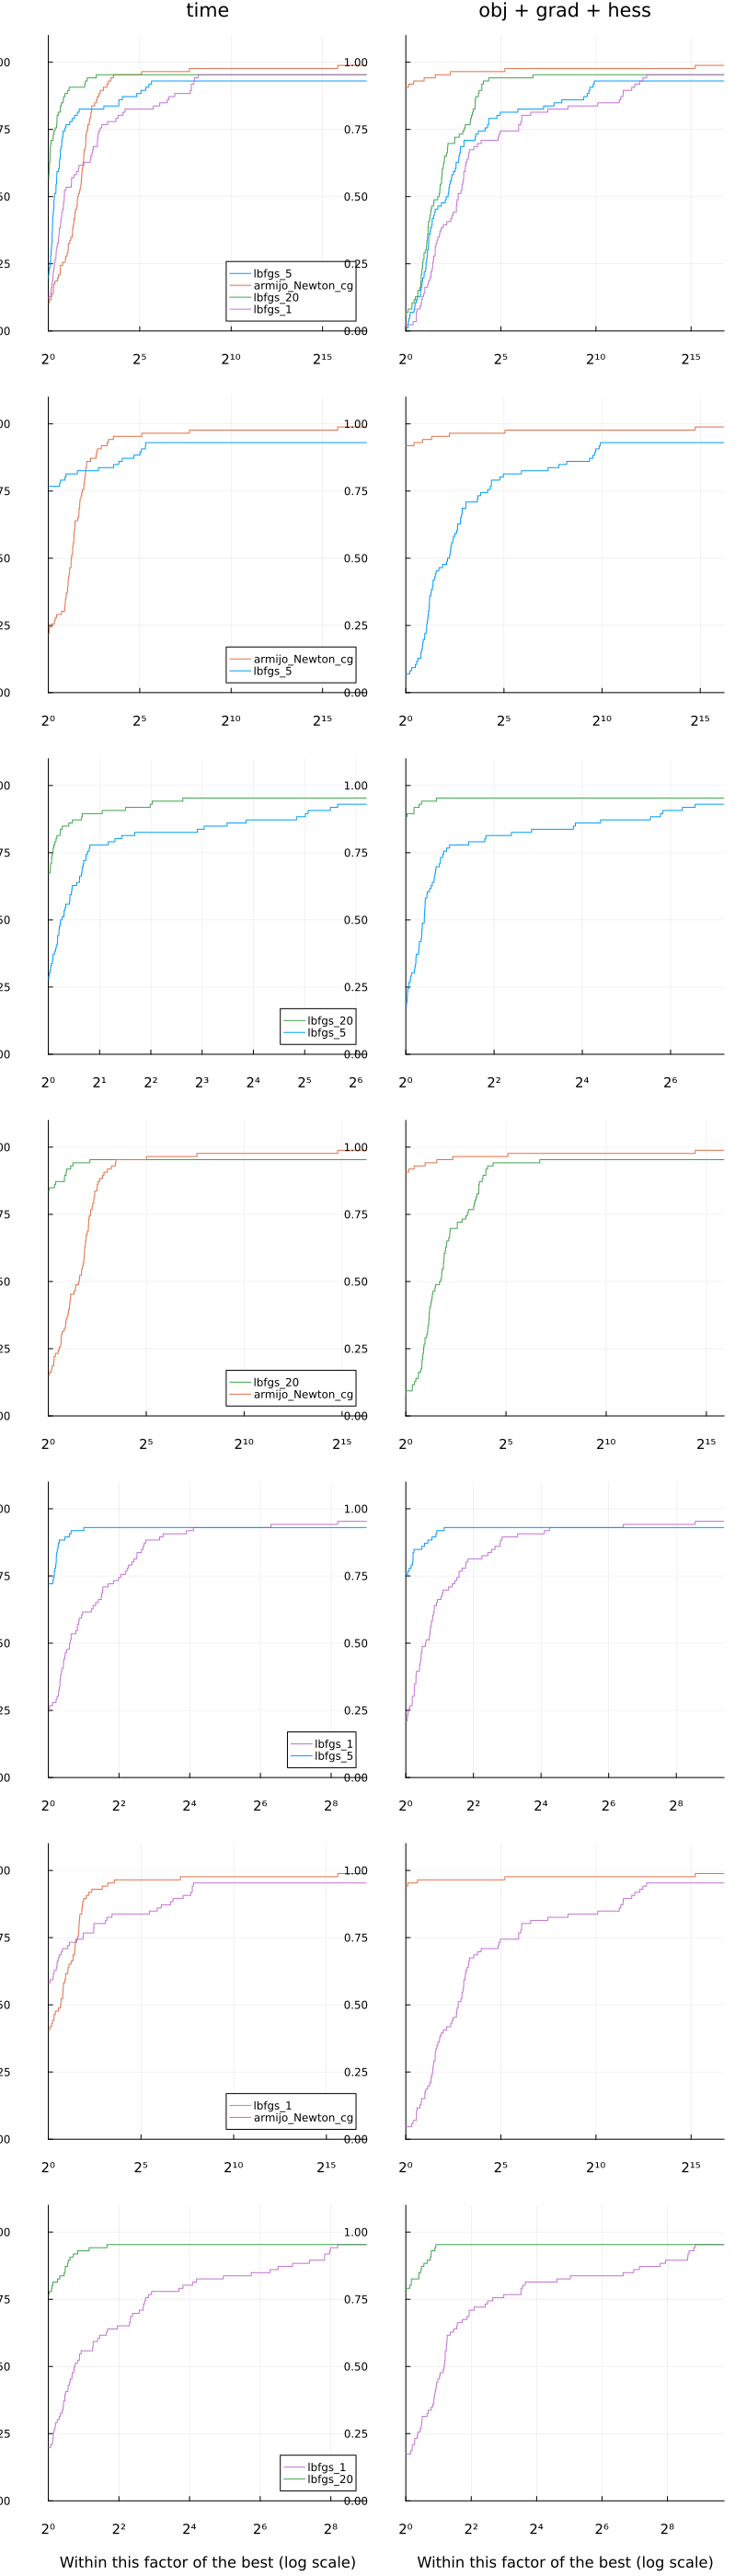

In [90]:
profile_solvers(stats, costs, costnames)

Ici on choisit 86 problemes de la banque ADNLPProblems pour comparer tous les algorithmes:

* Profile de performance de temps: on remarque que pour une mémoire limitée de 20, lbfgs arrive à performer contre tous les autres solveurs, en effet il arrive à résoudre le plus rapidement 50% des problemes et à performer sur 90% des problèmes avec un budget de temps 2^2 fois celui du meilleur solveur. Il est suivi par armijo qui lui requiert 2 fois plus de temps ceci est du à la résolution du système linéaire de Newton à chaque itération utilisant CG.

* Profil de performance en évaluation: on s'attend à ce que armijo_Newton_cg performe le mieux (heureusement) car il utilise une information exacte de la hessienne contrairement au lbfgs il arrive à résoudre efficacement 80% des problèmes avec le moindre nombre d'évaluation. De plus il est suivi par lbfgs_20 qui lui requiert 2^4 plus de budget. Et on constate que plus la mémoire du lbfgs est petite plus ça requiert plus d'évaluations ce qui est prévisible.

Les comparaisons 2 à 2 montrent que essentiellement armijo_Newton_cg et lbfgs_20 sont les meilleurs respectivement en termes de performances du nombre d'évaluation et de temps.

Enfin, le dernier graphe comparant armijo_newton à lbfgs_10 montre que d'une part lbfg_20 arrive à resoudre 80% des problemes plus rapidement que armijo_Newton_CG et ce dernier requiert 4 fois plus de temps pour achever cet objectif, alors que armijo_Newton_CG arrive à resoudre 90% des problemes plus rapidement que lbfg_20 et ce dernier requiert 2^4 fois plus de temps pour achever cet objectif.
Dépandant de ce qui nous intéresse comme propriété (temps ou évaluation) aucun n'est pour le moment le gagnant.
Néamoins, je dirais que vu la différence énorme en terme de temps qui dépasse celle du nombre d'évaluations (4 vs 2^4), je choisirai armijo_Newton_CG aulieu de lbfgs_20 et ceci est en accord avec la théorie car il utilise la hessienne exacte (par différence automatique).

In [111]:
cols = [:id, :name, :nvar, :objective, :dual_feas, :neval_obj, :neval_grad, :neval_hess, :iter, :elapsed_time, :status]
header = Dict(
  :nvar => "n",
  :objective => "f(x)",
  :dual_feas => "‖∇f(x)‖",
  :neval_obj => "# f",
  :neval_grad => "# ∇f",
  :neval_hess => "# ∇²f",
  :elapsed_time => "t",
)

In [115]:
lbfgs20_not_resolved = []
for i in eachrow(stats[:lbfgs_20][!, cols])
    if i[:status] != :first_order
        push!(lbfgs20_not_resolved, i[:name])
    end
end
armijo_Newton_cg_not_resolved = []
for i in eachrow(stats[:armijo_Newton_cg][!, cols])
    if i[:status] != :first_order
        push!(armijo_Newton_cg_not_resolved, i[:name])
    end
end
lbfgs5_not_resolved = []
for i in eachrow(stats[:lbfgs_5][!, cols])
    if i[:status] != :first_order
        push!(lbfgs5_not_resolved, i[:name])
    end
end
lbfgs1_not_resolved = []
for i in eachrow(stats[:lbfgs_1][!, cols])
    if i[:status] != :first_order
        push!(lbfgs1_not_resolved, i[:name])
    end
end

In [116]:
lbfgs20_not_resolved

5-element Vector{Any}:
 "NZF1"
 "biggs6"
 "indef"
 "osborne1"
 "scosine"

In [117]:
lbfgs1_not_resolved

4-element Vector{Any}:
 "NZF1"
 "biggs6"
 "osborne1"
 "scosine"

In [118]:
lbfgs5_not_resolved

7-element Vector{Any}:
 "NZF1"
 "biggs6"
 "curly20"
 "curly30"
 "indef"
 "osborne1"
 "scosine"

In [114]:
armijo_Newton_cg_not_resolved

2-element Vector{Any}:
 "biggs6"
 "scosine"

Voici les problèmes qui sont pas été résolus à l'optimalité par tous les algorithmes, on voit que notamment armijo_Newton_CG échoue à résoudre le moindre nombre de problèmes (2) ce qui renforce l'argument sur son choix!

### Appendix:

Une petite remarque sur la gestion de la mémoire:

In [ ]:
#Pour les nombres:
a = 1
@show a
b = a
@show b
a = 2
@show b

In [ ]:
#Pour les tableaux:
a = zeros(Float64, 2) #or zeros(2)
@show a
b = a
@show (a,b)
a = ones(Float64, 2)
@show (a,b)

#Pour les tableaux:
a = ones(Float64, 2)
b = a
@show (a,b)
a .= 2*ones(Float64, 2) #same would go with grad!
@show (a,b)

#Pour les tableaux:
a = ones(Float64, 2)
b = copy(a) # or similar(a)
@show (a,b)
a .= 2 .* ones(Float64, 2) #same would go with grad!
@show (a,b)

In [ ]:
#Pour les NLPModels, il existe aussi des fonctions qui interviennent sur la mémoire
gk = grad(nlp, x0)
grad!(nlp, x0, gk) #équivaut à gk .= grad(nlp, x0)

Comparez les `grad` et `grad!` à l'aide de `@benchmark` ainsi que:


In [ ]:
n = 10000
a = rand(n)
b = ones(n)
c = similar(a)
@benchmark c = 2 * a + b * 1.2


et

In [ ]:
@benchmark c .= 2 .* a .+ b .* 1.2

En particulier, observez la mémoire allouée et le temps moyen requis pour performer la ligne d'instruction.
La mémoire nécessaire varie en fonction du nombre et du type d'opération effectué.
Parmis les opérations allouant le moins de mémoire, on retrouve:

In [ ]:
@benchmark c .= 0

Pour manipuler plus finement la mémoire au cours de votre implémentation, vous pouvez utilisez des fonctions de `LinearAlgebra`

In [ ]:
? axpy!
? axpby!

qui sont des routines `BLAS`.
Faites attention, ces routines ont des effets de bord sur les structures de données `y`.
Dès lors, l'utilisation de `@benchmark` accumule successivement les effets de bord, d'où l'utilisation des tests avant `@benchmark`.

In [ ]:
y = zeros(n)
x = ones(n)
a = 2
axpy!(a, x, y)
@show y == a * x

@benchmark axpy!(a, x, y)

In [ ]:
y = π * ones(n)
x = ones(n)
a = 2
b = 3
axpby!(a, x, b, y)
@show y == a * ones(n) + b * π * ones(n)

@benchmark axpby!(a, x, b, y)

Cela fontionne aussi pour les matrices

In [ ]:
y = π * ones(n,n)
x = ones(n,n)
a = 2
b = 3
axpby!(a, x, b, y)
@show y == a * ones(n,n) + b * π * ones(n,n)

@benchmark axpby!(a, x, b, y)